In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from model.aotgan import InpaintGenerator

import utils

import torch
import os
import pandas as pd 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import cv2
import numpy as np 


In [7]:
ts_img_dir = '/mnt/HDD/octc/mask_abstract/test'
ts_mask_dir = '/mnt/HDD/octc/mask_abstract/mask'

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(
    image_dir = ts_img_dir,
    mask_dir = ts_mask_dir,
    transform= test_transform,
    mask_transform= test_transform,
    testing = True,
    mask_shuffle = False,
)
ts_batch = 16
test_loader = DataLoader(dataset = test_dataset, batch_size = ts_batch, shuffle = False)


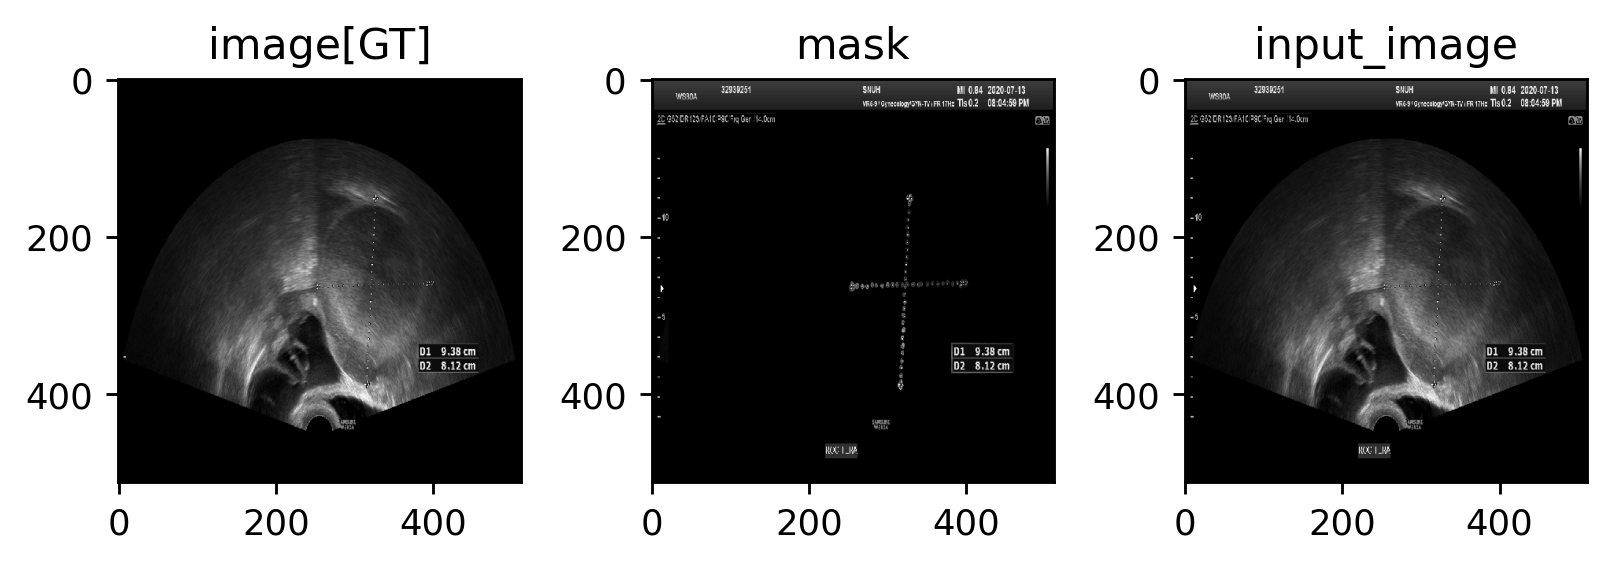

In [8]:
def plotting(images, masks, input_images):
    plt.figure(dpi =256)
    plt.subplot(131)
    plt.imshow(images[1,0], cmap= 'gray')
    plt.title('image[GT]')
    plt.subplot(132)
    plt.imshow(masks[1,0 ], cmap= 'gray')
    plt.title('mask')
    plt.subplot(133)
    plt.imshow(input_images[1,0 ], cmap= 'gray')
    plt.title('input_image')
    plt.tight_layout()
    plt.show()

for images, masks, paths in test_loader:
    # mask가 0이 아닌 부분에 대해 image를 mask로 대체
    input_images = images.clone()
    # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
    input_images[masks != 0] = masks[masks != 0] 
        
    # input_images 처리해줫으니 다시 masks를 1채널로 변경
    masks = masks[:,0,:,:].unsqueeze(1)
    plotting(images, masks, input_images)
    break


In [9]:
load_path = '/mnt/HDD/oci_models/aotgan/OCI-GAN_v3_240508/model_64.pt'
save_path = '/mnt/HDD/oci_models/aotgan/OCI-GAN_v3_240508/result_ext'
visual_save_path = '/mnt/HDD/oci_models/aotgan/OCI-GAN_v3_240508/visual_ext'
os.makedirs(save_path, exist_ok= True)
os.makedirs(visual_save_path, exist_ok= True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
netG = InpaintGenerator().to(device)
G_check = torch.load(load_path)['netG_state_dict']
netG.load_state_dict(G_check)



<All keys matched successfully>

In [10]:
from utils.metric import calculate_and_log_metrics, compare_fid
metric = {
    'mae' : 0,
    'mse' : 0, 
    'psnr' : 0,
    'ssim' : 0,
    'fid' : 0
}

2024-05-09 13:21:54.545779: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 13:21:54.546937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:21:54.568329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 13:21:55.043495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
mae_sum, mse_sum, psnr_sum, ssim_sum = 0, 0, 0, 0
total_samples = len(test_loader.dataset)

with torch.no_grad():

    netG.eval()
    for images, masks, image_paths in test_loader:
        images, masks = images.to(device), masks.to(device)
        ### 전처리
        # mask가 0이 아닌 부분에 대해 image를 mask로 대체
        input_images = images.clone()
        # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
        input_images[masks != 0] = masks[masks != 0] 
        # input_images 처리해줫으니 다시 masks를 1채널로 변경
        masks = masks[:,0,:,:].unsqueeze(1)
        # 입력이미지 device 할당
        input_images = input_images.to(device) 

        ### inference
        pred_images = netG(input_images, masks)  # 3+1ch
        
        ## mask에서 0이 아닌 부분을 GT로 대체, 이때 마스크는 0~1사이의 값을 가짐 
        comp_images = images.clone()
        comp_images[masks.repeat(1,3,1,1) != 0] = pred_images[masks.repeat(1,3,1,1) != 0] #comp_image를 남겨두는 이유는 result를 확인하기 위함 

        # metric를 평가하기 위해 metric_images와 pred_images에서 mask와 같은 인덱스인 부분을 제외하고 0으로 만들기 
        metric_gt, metric_pred = images.clone(), pred_images.clone()
        metric_gt[masks.repeat(1,3,1,1) == 0] = 0
        metric_pred[masks.repeat(1,3,1,1) == 0] = 0
        
        # metric 계산 : mask인 부분만 계산! 
        for i in range(images.size(0)):
            mae, mse, psnr, ssim = calculate_and_log_metrics(metric_gt[i,0].cpu().detach().numpy(), metric_pred[i,0].cpu().detach().numpy())
            mae_sum += mae 
            mse_sum += mse 
            psnr_sum += psnr
            ssim_sum += ssim
        fid = compare_fid(metric_gt, metric_pred) 
        
        metric['mae'] += mae_sum / total_samples
        metric['mse'] += mse_sum / total_samples
        metric['psnr'] += psnr_sum / total_samples
        metric['ssim'] += ssim_sum / total_samples
        metric['fid'] += fid / len(test_loader)

        #img_save
        for input_image, mask, pred_image, path in zip(input_images, masks, comp_images, image_paths):
            file_name = path.split('/')[-1]
            # Origianl Image 대로 Resize
            original_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            utils.test_plotting(input_image, mask, pred_image, save_path = os.path.join(visual_save_path, file_name))

            pred_image = pred_image.cpu().detach().numpy()
            # Transpose pred_image from (C, H, W) to (H, W, C) for OpenCV compatibility
            pred_image = np.transpose(pred_image, (1, 2, 0))
            # Now, resize pred_image to match the original image's dimensions
            pred_image = cv2.resize(pred_image, (original_image.shape[1], original_image.shape[0]))  # Note the order of shape
            pred_image = np.clip(pred_image * 255, 0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
            cv2.imwrite(os.path.join(save_path, file_name), pred_image)
# metric save 
df = pd.DataFrame([metric])
df.to_csv(os.path.join(visual_save_path, 'metric.csv'), index = False)

2024-05-09 13:22:05.493619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 13:22:05.494716: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 0s 144ms/step


# Application External Data Check

1647

206